#### 데이터 불러오기


In [1]:
#For more detail preprocessing script, please refer 'PyConKorea2019-Tutorials/LRP/preprocessing.ipynb'
import pickle
import numpy as np
#load 
with open("nsmc_train_x.txt", "rb") as fp:
    X_train = pickle.load(fp)
with open("nsmc_test_x.txt", "rb") as fp:
    X_test = pickle.load(fp)
with open("nsmc_train_y.txt", "rb") as fp:
    train_y = pickle.load(fp)
with open("nsmc_test_y.txt", "rb") as fp:
    test_y = pickle.load(fp)
with open("nsmc_selected_words.txt", "rb") as fp:
    selected_words_10000 = pickle.load(fp) 

### 데이터 전처리



In [10]:
def read_data(filename):
    with open(filename, 'r') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        # txt 파일의 헤더(id document label)는 제외하기
        data = data[1:]
    return data

train_data = read_data('nsmc/ratings_train.txt')
test_data = read_data('nsmc/ratings_test.txt')

In [11]:
print(len(train_data))
print(len(train_data[0]))
print(len(test_data))
print(len(test_data[0]))

150000
3
50000
3


이제 데이터를 학습하기에 알맞게 처리를 해볼텐데요, KoNLPy 라이브러리를 이용해서 형태소 분석 및 품사 태깅을 하겠습니다.
이전 예제처럼 주어진 단어의 빈도만을 사용해서 처리해도 되지만 한국어는 영어와는 달리 띄어쓰기로 의미를 구분짓기에는 한계가 있고,
네이버 영화 데이터에는 맞춤법이나 띄어쓰기가 제대로 되어있지 않은 경우가 있기 때문에 정확한 분류를 위해서 KoNLPy를 이용하겠습니다.

KoNLPy는 띄어쓰기 알고리즘과 정규화를 이용해서 맞춤법이 틀린 문장도 어느 정도 고쳐주면서 형태소 분석과 품사를 태깅해주는 여러 클래스를 제공합니다. 링크참조
그 중에서 Okt(Open Korean Text) 클래스를 이용하겠습니다.

In [12]:
!pip install konlpy 

In [13]:
import konlpy

konlpy.__version__

'0.6.0'

Okt를 이용해서 간단하게 문장을 분석해보겠습니다.

In [14]:
from konlpy.tag import Okt

okt = Okt()
print(okt.pos(u'이 밤 그날의 반딧불을 당신의 창 가까이 보낼게요'))

[('이', 'Noun'), ('밤', 'Noun'), ('그날', 'Noun'), ('의', 'Josa'), ('반딧불', 'Noun'), ('을', 'Josa'), ('당신', 'Noun'), ('의', 'Josa'), ('창', 'Noun'), ('가까이', 'Noun'), ('보낼게요', 'Verb')]


이제 아까 불러온 데이터에 형태소 분석을 통해서 품사를 태깅해주는 작업을 하겠습니다.
데이터의 양이 큰 만큼 시간이 오래 걸리기 때문에 이 작업을 반복하지 않도록 한 번 태깅을 마친 후에는 json 파일로 저장하는 것을 추천합니다.
여기에서는 이미 태깅이 완료된 train_docs.json 파일이 존재하면 반복하지 않도록 만들었습니다.

In [15]:
import json
import os
from pprint import pprint

def tokenize(doc):
    # norm은 정규화, stem은 근어로 표시하기를 나타냄
    return ['/'.join(t) for t in okt.pos(doc, norm=True, stem=True)]

if os.path.isfile('nsmc/train_docs.json'):
    with open('nsmc/train_docs.json') as f:
        train_docs = json.load(f)
    with open('nsmc/test_docs.json') as f:
        test_docs = json.load(f)
else:
    train_docs = [(tokenize(row[1]), row[2]) for row in train_data]
    test_docs = [(tokenize(row[1]), row[2]) for row in test_data]
    # JSON 파일로 저장
    with open('nsmc/train_docs.json', 'w', encoding="utf-8") as make_file:
        json.dump(train_docs, make_file, ensure_ascii=False, indent="\t")
    with open('nsmc/test_docs.json', 'w', encoding="utf-8") as make_file:
        json.dump(test_docs, make_file, ensure_ascii=False, indent="\t")

# 예쁘게(?) 출력하기 위해서 pprint 라이브러리 사용
pprint(train_docs[0])

[['아/Exclamation',
  '더빙/Noun',
  '../Punctuation',
  '진짜/Noun',
  '짜증나다/Adjective',
  '목소리/Noun'],
 '0']


분석한 데이터의 토큰(문자열을 분석을 위한 작은 단위)의 갯수를 확인해봅시다.

In [16]:
tokens = [t for d in train_docs for t in d[0]]
print(len(tokens))

2159921


이제 이 데이터를 nltk 라이브러리를 통해서 전처리를 해볼텐데요, Text 클래스는 문서를 편리하게 탐색할 수 있는 다양한 기능을 제공합니다.
여기에서는 vocab().most_common 메서드를 이용해서 데이터에서 가장 자주 사용되는 단어를 가져올 때 사용하겠습니다.



In [17]:
import nltk
text = nltk.Text(tokens, name='NMSC')
print(text)

<Text: NMSC>


In [18]:
# 전체 토큰의 개수
print(len(text.tokens))

# 중복을 제외한 토큰의 개수
print(len(set(text.tokens)))            

# 출현 빈도가 높은 상위 토큰 10개
pprint(text.vocab().most_common(10))

2159921
49895
[('./Punctuation', 67778),
 ('영화/Noun', 50818),
 ('하다/Verb', 41209),
 ('이/Josa', 38540),
 ('보다/Verb', 38538),
 ('의/Josa', 30188),
 ('../Punctuation', 29055),
 ('가/Josa', 26627),
 ('에/Josa', 26468),
 ('을/Josa', 23118)]


자주 나오는 단어 50개를 matplotlib 라이브러리를 통해서 그래프로 나타내보겠습니다.

한편 한글 폰트를 로드해야 글씨가 깨지지 않고 출력이 되는데요,
윈도우에서는 font_fname 을 'c:/windows/fonts/gulim.ttc',
리눅스에서는 /usr/share/fonts/nanumfont/NanumGothic.ttf 등으로 설정해야 합니다.

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50689 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54616 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45796 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_

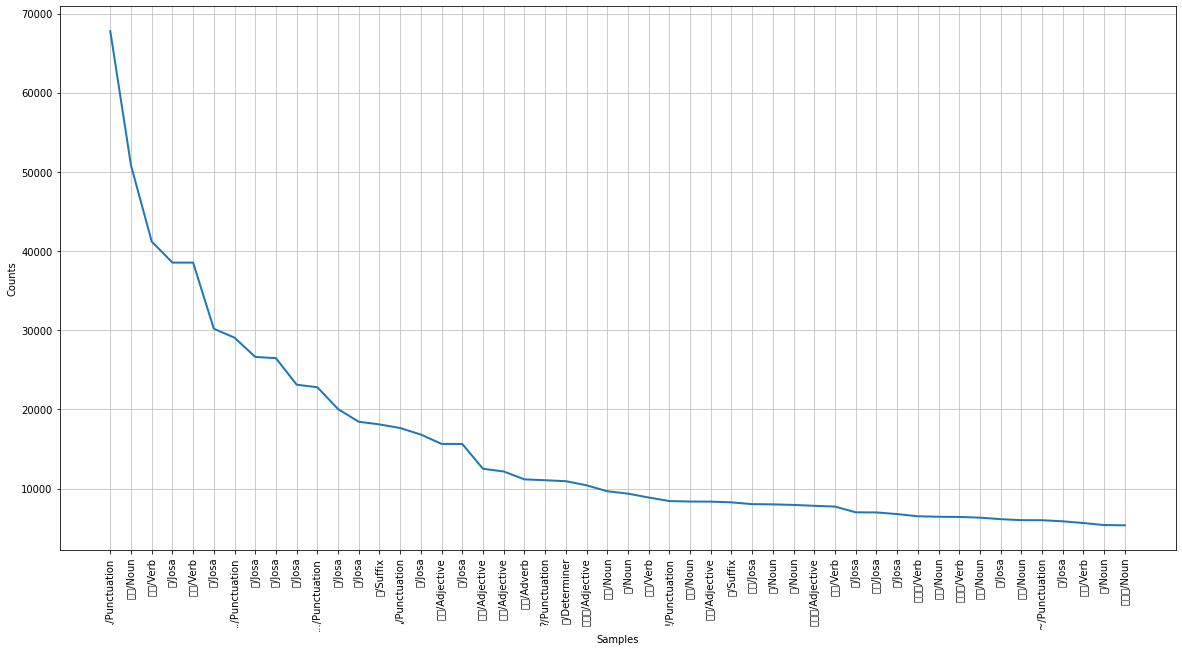

In [19]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline

font_fname = 'Fonts/applegothic.ttf'
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)

plt.figure(figsize=(20,10))
text.plot(50)

이제 자주 사용되는 토큰 10000개를 사용해서 데이터를 벡터화를 시키겠습니다.
여기서는 원 핫 인코딩 대신에 CountVectorization을 사용했습니다.
이는 문서 집합에서 단어 토큰을 생성하고 각 단어의 수를 세어 BOW(Bag of Words) 인코딩한 벡터를 만드는 역할을 합니다.

In [20]:
#10000개로 하니 자꾸 Ram이 터졌습니다..ㅠ
#5000개로 줄여봤습니다.
#빠른 학습을 위해 1000으로 했습니다.
selected_words = [f[0] for f in text.vocab().most_common(1000)]

def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

train_x = [term_frequency(d) for d, _ in train_docs]
test_x = [term_frequency(d) for d, _ in test_docs]
train_y = [c for _, c in train_docs]
test_y = [c for _, c in test_docs]

이제 데이터를 float로 형 변환 시켜주면 데이터 전처리 과정은 끝납니다

In [26]:
import numpy as np

x_train = np.asarray(train_x).astype('float32')
x_test = np.asarray(test_x).astype('float32')

y_train = np.asarray(train_y).astype('float32')
y_test = np.asarray(test_y).astype('float32')

저번의 영화 리뷰에서 사용했던 모델을 조금 변형했습니다.
구조는 다음과 같습니다.
두 개의 Dense 층은 64개의 유닛을 가지고 활성화 함수로는 relu를 사용했으며, 마지막 층은 sigmoid 활성화 함수를 사용해서 긍정의 리뷰일 확률을 출력합니다.
손실 함수로는 binary_crossentropy를 사용했고 RMSProp 옵티마이저를 통해서 경사하강법을 진행했습니다.
또한 배치 사이즈를 512로, 에포크를 10번으로 학습시켰습니다.

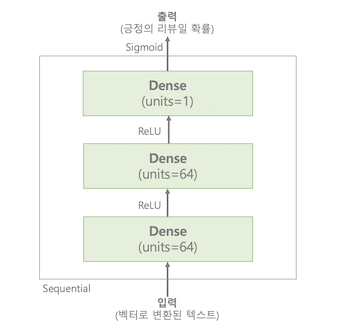

In [22]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(1000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss=losses.binary_crossentropy,
             metrics=[metrics.binary_accuracy])

model.fit(x_train, y_train, epochs=10, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/10
293/293 [==============================] - 1s 3ms/step - loss: 0.4352 - binary_accuracy: 0.8017
Epoch 2/10
293/293 [==============================] - 1s 3ms/step - loss: 0.3812 - binary_accuracy: 0.8241
Epoch 3/10
293/293 [==============================] - 1s 3ms/step - loss: 0.3648 - binary_accuracy: 0.8320
Epoch 4/10
293/293 [==============================] - 1s 3ms/step - loss: 0.3516 - binary_accuracy: 0.8412
Epoch 5/10
293/293 [==============================] - 1s 3ms/step - loss: 0.3395 - binary_accuracy: 0.8483
Epoch 6/10
293/293 [==============================] - 1s 3ms/step - loss: 0.3282 - binary_accuracy: 0.8548
Epoch 7/10
293/293 [==============================] - 1s 3ms/step - loss: 0.3174 - binary_accuracy: 0.8607
Epoch 8/10
293/293 [==============================] - 1s 3ms/step - loss: 0.3062 - binary_accuracy: 0.8660
Epoch 9/10
293/293 [==============================] - 1s 3ms/step - loss: 0.2948 - binary_accuracy: 0.8724
Epoch 10/10
1563/1563 [==============

테스트 데이터로 확인해본 결과를 출력해보면 85%의 성능을 보여주는 것을 알 수 있습니다.


In [23]:
results

[0.3988867998123169, 0.8276200294494629]

이제 문자열 형태의 새로운 데이터를 받아와서 바로 결과를 예측하는 함수를 만들어 보겠습니다.
데이터의 형태를 맞춰주기 위해서 달리 np.expand_dims 메서드를 이용해 array의 축을 확장시켰습니다.
최종 확률이 0.5 보다 크면 긍정이고, 그렇지 않으면 부정이라고 예측했습니다.

In [24]:
def predict_pos_neg(review):
    token = tokenize(review)
    tf = term_frequency(token)
    data = np.expand_dims(np.asarray(tf).astype('float32'), axis=0)
    score = float(model.predict(data))
    if(score > 0.5):
        print("[{}]는 {:.2f}% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^\n".format(review, score * 100))
    else:
        print("[{}]는 {:.2f}% 확률로 부정 리뷰이지 않을까 추측해봅니다.^^;\n".format(review, (1 - score) * 100))

이렇게 여러 가지 한글 리뷰를 넣어서 예측하게 됩니다.

In [25]:
predict_pos_neg("올해 최고의 영화! 세 번 넘게 봐도 질리지가 않네요.")
predict_pos_neg("배경 음악이 영화의 분위기랑 너무 안 맞았습니다. 몰입에 방해가 됩니다.")
predict_pos_neg("주연 배우가 신인인데 연기를 진짜 잘 하네요. 몰입감 ㅎㄷㄷ")
predict_pos_neg("믿고 보는 감독이지만 이번에는 아니네요")
predict_pos_neg("주연배우 때문에 봤어요")

[올해 최고의 영화! 세 번 넘게 봐도 질리지가 않네요.]는 98.08% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^

[배경 음악이 영화의 분위기랑 너무 안 맞았습니다. 몰입에 방해가 됩니다.]는 86.28% 확률로 부정 리뷰이지 않을까 추측해봅니다.^^;

[주연 배우가 신인인데 연기를 진짜 잘 하네요. 몰입감 ㅎㄷㄷ]는 84.32% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^

[믿고 보는 감독이지만 이번에는 아니네요]는 59.23% 확률로 부정 리뷰이지 않을까 추측해봅니다.^^;

[주연배우 때문에 봤어요]는 89.67% 확률로 부정 리뷰이지 않을까 추측해봅니다.^^;



### LSTM 훈련

In [27]:
import numpy as np
import keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.models import Model, load_model

import matplotlib.pyplot as plt
from IPython.display import display, HTML

from numpy import newaxis as na

max_features = 10000

maxlen = 100

batch_size = 1024

In [28]:
max_features = 10000

maxlen = 100

batch_size = 1024

# One-hot encoding the output >> 
num_classes = 2

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense

y_train = keras.utils.to_categorical(train_y, num_classes)

y_test = keras.utils.to_categorical(test_y, num_classes)

In [15]:
#! pip install tensorflow==2.3.0

     |████████████████████████████████| 320.4 MB 46 kB/s 
     |████████████████████████████████| 2.9 MB 35.5 MB/s 
     |████████████████████████████████| 20.1 MB 30.6 MB/s 
     |████████████████████████████████| 459 kB 40.1 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.7.0
    Uninstalling tensorflow-2.7.0:


In [16]:
#! pip install keras==2.4.0

     |████████████████████████████████| 170 kB 7.9 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0


In [29]:
# One-hot encoding the output >> 
num_classes = 2

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense





y_train = keras.utils.to_categorical(train_y, num_classes)

y_test = keras.utils.to_categorical(test_y, num_classes)

In [30]:
print('훈련 데이터: {}'.format(len(X_train)))
print('테스트 데이터: {}'.format(len(X_test)))
print('카테고리: {}'.format(num_classes))

훈련 데이터: 150000
테스트 데이터: 50000
카테고리: 2


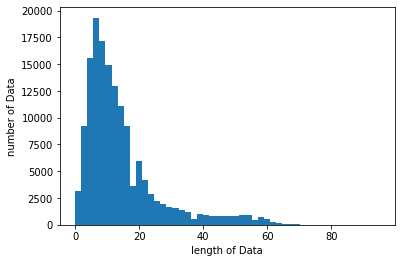

In [31]:
plt.hist([len(s) for s in X_train], bins=50) #50개로 쪼개기
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

maxlen = 30

x_train = sequence.pad_sequences(X_train, maxlen)

x_test = sequence.pad_sequences(X_test, maxlen)

In [32]:
maxlen = 30
x_train = sequence.pad_sequences(X_train, maxlen)
x_test = sequence.pad_sequences(X_test, maxlen)

In [33]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=3)

Train...
Epoch 1/3
147/147 [==============================] - 20s 133ms/step - loss: 0.4462 - accuracy: 0.7887
Epoch 2/3
147/147 [==============================] - 20s 133ms/step - loss: 0.3253 - accuracy: 0.8589
Epoch 3/3
147/147 [==============================] - 20s 134ms/step - loss: 0.3063 - accuracy: 0.8673


In [ ]:

# from keras.models import load_model
# model = load_model('lstm.h5')

In [34]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total params: 1,411,842
Trainable params: 1,411,842
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.evaluate(x_test, y_test)

1563/1563 [==============================] - 17s 11ms/step - loss: 0.3487 - accuracy: 0.8444


[0.3486810624599457, 0.8444200158119202]

 ### LRP & Visualization

In [36]:
def html_heatmap (words, scores, cmap_name="bwr"):
    """
    Return word-level heatmap in HTML format,
    with words being the list of words (as string),
    scores the corresponding list of word-level relevance values,
    and cmap_name the name of the matplotlib diverging colormap.
    """
    
    colormap  = plt.get_cmap(cmap_name)
     
    #assert len(words)==len(scores)
    max_s     = max(scores)
    min_s     = min(scores)
    
    output_text = ""
    
    for idx, w in enumerate(words):
        score       = rescale_score_by_abs(scores[idx], max_s, min_s)
        output_text = output_text + span_word(w, score, colormap) + " "
    
    return output_text + "\n"

def rescale_score_by_abs (score, max_score, min_score):
    """
    Normalize the relevance value (=score), accordingly to the extremal relevance values (max_score and min_score), 
    for visualization with a diverging colormap.
    i.e. rescale positive relevance to the range [0.5, 1.0], and negative relevance to the range [0.0, 0.5],
    using the highest absolute relevance for linear interpolation.
    """
    
    # CASE 1: positive AND negative scores occur --------------------
    if max_score>0 and min_score<0:
    
        if max_score >= abs(min_score):   # deepest color is positive
            if score>=0:
                return 0.5 + 0.5*(score/max_score)
            else:
                return 0.5 - 0.5*(abs(score)/max_score)

        else:                             # deepest color is negative
            if score>=0:
                return 0.5 + 0.5*(score/abs(min_score))
            else:
                return 0.5 - 0.5*(score/min_score)   
    
    # CASE 2: ONLY positive scores occur -----------------------------       
    elif max_score>0 and min_score>=0: 
        if max_score == min_score:
            return 1.0
        else:
            return 0.5 + 0.5*(score/max_score)
    
    # CASE 3: ONLY negative scores occur -----------------------------
    elif max_score<=0 and min_score<0: 
        if max_score == min_score:
            return 0.0
        else:
            return 0.5 - 0.5*(score/min_score)
          

def getRGB (c_tuple):
    return "#%02x%02x%02x"%(int(c_tuple[0]*255), int(c_tuple[1]*255), int(c_tuple[2]*255))

     
def span_word (word, score, colormap):
    return "<span style=\"background-color:"+getRGB(colormap(score))+"\">"+word+"</span>"

In [82]:
class LRP4LSTM(object):
    def __init__(self, model):
        
        self.model = model
        
        names = [weight.name for layer in model.layers for weight in layer.weights]
        weights = model.get_weights()

        # suppress scientific notation
        np.set_printoptions(suppress=True)
        for name, weight in zip(names, weights):
            if name == 'lstm_1/kernel:0':
                kernel_0 = weight
            if name == 'lstm_1/recurrent_kernel:0':
                recurrent_kernel_0 = weight
            if name == 'lstm_1/bias:0':
                bias_0 = weight
            elif name == 'dense_1/kernel:0':
                output = weight



        print("kernel_0", kernel_0.shape)
        print("recurrent_kernel_0", recurrent_kernel_0.shape)
        print("bias_0", bias_0.shape)
        print("output", output.shape)

        # self.Wxh_Left (240, 60)
        # self.Whh_Left (240, 60)
        # self.bxh_Left (240,)
        # self.Why_Left (5, 60)

        self.Wxh = kernel_0.T  # shape 4d*e
        self.Whh = recurrent_kernel_0.T  # shape 4d
        self.bxh = bias_0.T  # shape 4d 
        self.Why = output.T
        
    def lrp_linear(self, hin, w, b, hout, Rout, bias_nb_units, eps, bias_factor=1.0, debug=False):
        """
        LRP for a linear layer with input dim D and output dim M.
        Args:
        - hin:            forward pass input, of shape (D,)
        - w:              connection weights, of shape (D, M)
        - b:              biases, of shape (M,)
        - hout:           forward pass output, of shape (M,) (unequal to np.dot(w.T,hin)+b if more than one incoming layer!)
        - Rout:           relevance at layer output, of shape (M,)
        - bias_nb_units:  total number of connected lower-layer units (onto which the bias/stabilizer contribution is redistributed for sanity check)
        - eps:            stabilizer (small positive number)
        - bias_factor:    set to 1.0 to check global relevance conservation, otherwise use 0.0 to ignore bias/stabilizer redistribution (recommended)
        Returns:
        - Rin:            relevance at layer input, of shape (D,)
        """
        sign_out = np.where(hout[na,:]>=0, 1., -1.) # shape (1, M)

        numer    = (w * hin[:,na]) + ( bias_factor * (b[na,:]*1. + eps*sign_out*1.) / bias_nb_units ) # shape (D, M)
        # Note: here we multiply the bias_factor with both the bias b and the stabilizer eps since in fact
        # using the term (b[na,:]*1. + eps*sign_out*1.) / bias_nb_units in the numerator is only useful for sanity check
        # (in the initial paper version we were using (bias_factor*b[na,:]*1. + eps*sign_out*1.) / bias_nb_units instead)

        denom    = hout[na,:] + (eps*sign_out*1.)   # shape (1, M)

        message  = (numer/denom) * Rout[na,:]       # shape (D, M)

        Rin      = message.sum(axis=1)              # shape (D,)

        if debug:
            print("local diff: ", Rout.sum() - Rin.sum())
        # Note: 
        # - local  layer   relevance conservation if bias_factor==1.0 and bias_nb_units==D (i.e. when only one incoming layer)
        # - global network relevance conservation if bias_factor==1.0 and bias_nb_units set accordingly to the total number of lower-layer connections 
        # -> can be used for sanity check

        return Rin
        
    def get_layer_output(self, layer_name, data):
        # https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer
        intermediate_layer_model = keras.Model(inputs=self.model.input,
                                         outputs=self.model.get_layer(layer_name).output)
        return intermediate_layer_model.predict(data)  
    
    def run(self, target_data, target_class):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))
        
        #원본 소스에서 E embedding은 전체에 대한 단어 사전이고, x는 embedding된 인풋이다.  
        # w_indices [109, 11995, 25, 18263, 25, 973, 3138, 6389, 372]

        x = self.get_layer_output('embedding_1', target_data).squeeze(axis=1)
        e = x.shape[1]

       ################# forword
        T = target_data.shape[0]
        d = int(512/4)  # hidden units
        C = self.Why.shape[0] # number of classes

        idx    = np.hstack((np.arange(0,d), np.arange(2*d,4*d))).astype(int) # indices of gates i,f,o together
        idx_i, idx_f, idx_c, idx_o = np.arange(0,d), np.arange(d,2*d), np.arange(2*d,3*d), np.arange(3*d,4*d) # indices of gates i,g,f,o separately

        # 최종적으로 구하려는 값은 c에 저장될 값과 h으로 지워질 값
        h  = np.zeros((T,d))
        c  = np.zeros((T,d))

        gates_pre = np.zeros((T, 4*d))  # gates pre-activation
        gates     = np.zeros((T, 4*d))  # gates activation

        for t in range(T):

            gates_pre[t]    = np.dot(self.Wxh, x[t]) + np.dot(self.Whh, h[t-1]) + self.bxh

            gates[t,idx]    = sigmoid(gates_pre[t,idx])
            gates[t,idx_c]  = np.tanh(gates_pre[t,idx_c]) 

            c[t]            = gates[t,idx_f]*c[t-1] + gates[t,idx_i]*gates[t,idx_c]
            h[t]            = gates[t,idx_o]*np.tanh(c[t])

        score = np.dot(self.Why, h[t])    

        ################# backwork
        dx     = np.zeros(x.shape)

        dh          = np.zeros((T, d))
        dc          = np.zeros((T, d))
        dgates_pre  = np.zeros((T, 4*d))  # gates pre-activation
        dgates      = np.zeros((T, 4*d))  # gates activation

        ds               = np.zeros((C))
        ds[target_class] = 1.0
        dy               = ds.copy()

        #맨처음을 0으로 시작하지 않게 위한조치
        dh[T-1]     = np.dot(self.Why.T, dy)

        for t in reversed(range(T)): 
            dgates[t,idx_o]    = dh[t] * np.tanh(c[t])  # do[t]
            dc[t]             += dh[t] * gates[t,idx_o] * (1.-(np.tanh(c[t]))**2) # dc[t]
            dgates[t,idx_f]    = dc[t] * c[t-1]         # df[t]
            dc[t-1]            = dc[t] * gates[t,idx_f] # dc[t-1]
            dgates[t,idx_i]    = dc[t] * gates[t,idx_c] # di[t]
            dgates[t,idx_c]    = dc[t] * gates[t,idx_i] # dg[t]
            dgates_pre[t,idx]  = dgates[t,idx] * gates[t,idx] * (1.0 - gates[t,idx]) # d ifo pre[t]
            dgates_pre[t,idx_c]= dgates[t,idx_c] *  (1.-(gates[t,idx_c])**2) # d c pre[t]
            dh[t-1]            = np.dot(self.Whh.T, dgates_pre[t])
            dx[t]              = np.dot(self.Wxh.T, dgates_pre[t])

        ################# LRP
        eps=0.001 
        bias_factor=1.0
        Rx  = np.zeros(x.shape)
        Rh  = np.zeros((T+1, d))
        Rc  = np.zeros((T+1, d))
        Rg  = np.zeros((T,   d)) # gate g only

        Rout_mask            = np.zeros((C))
        Rout_mask[target_class] = 1.0  

        # format reminder: lrp_linear(hin, w, b, hout, Rout, bias_nb_units, eps, bias_factor)
        Rh[T-1]  = self.lrp_linear(h[T-1], self.Why.T, np.zeros((C)), score, score*Rout_mask, d, eps, bias_factor, debug=False)  

        for t in reversed(range(T)):
            Rc[t]   += Rh[t]
            Rc[t-1]  = self.lrp_linear(gates[t,idx_f]*c[t-1], np.identity(d), np.zeros((d)), c[t], Rc[t], d, eps, bias_factor, debug=False)
            Rg[t]    = self.lrp_linear(gates[t,idx_i]*gates[t,idx_c], np.identity(d), np.zeros((d)), c[t], Rc[t], d, eps, bias_factor, debug=False)
            Rx[t]    = self.lrp_linear(x[t], self.Wxh[idx_c].T, self.bxh[idx_c], gates_pre[t,idx_c], Rg[t], d+e, eps, bias_factor, debug=False)
            Rh[t-1]  = self.lrp_linear(h[t-1], self.Whh[idx_c].T, self.bxh[idx_c], gates_pre[t,idx_c], Rg[t], d+e, eps, bias_factor, debug=False)    

        return score, x, dx, Rx, Rh[-1].sum()
print("얍")

얍


In [83]:
lrp = LRP4LSTM(model)

UnboundLocalError: ignored

In [72]:
def index_to_word(list):
    _ = []
    for x in list :
        _.append(selected_words_10000[x].split('/')[0])
    return _
  
def int_to_str(target_class):
    if target_class == 0 :
        return "부정"
    else :
        return "긍정"

In [74]:
predictions = model.predict(x_test)
predictions

array([[0.02797838, 0.9723093 ],
       [0.60801953, 0.39668548],
       [0.89232606, 0.11453594],
       ...,
       [0.08742093, 0.9099511 ],
       [0.938748  , 0.06070819],
       [0.65419984, 0.3376445 ]], dtype=float32)

In [75]:
positive_list = []
negative_list = []

for i in range(len(y_test)):
    if np.argmax(predictions[i]) == 1:
        positive_list.append(i)
    else :
        negative_list.append(i)

In [81]:
print("각 단어가 긍정이라고 예측하는데 영향을 미치는 정도" )
for index, i in enumerate(positive_list):
    
    target_full_data = x_test[i]
    target_data = target_full_data[target_full_data != 0]
    target_class = np.argmax(y_test[i])

    score, x, Gx, Rx, R_rest = lrp.run(target_data, target_class)

    R_words_SA       = (np.linalg.norm(Gx, ord=2, axis=0))**2   # compute word-level Sensitivity Analysis relevances
    R_words          = np.sum(Rx, axis=1)                       # compute word-level LRP relevances
    
    words = index_to_word(target_data) 

    if len(words) > 0 :
        print(" 예측 레이블:", int_to_str(np.argmax(predictions[i])), "| 실제 레이블 : ", int_to_str(target_class))

        print("        SA heatmap:")
        display(HTML(html_heatmap(words, R_words_SA)))
        
        print("        LRP heatmap:")
        display(HTML(html_heatmap(words, R_words)))

        print("-----------------------------------------------------------")

    if index == 20: # 20roaks 출력
      break

각 단어가 긍정이라고 예측하는데 영향을 미치는 정도


TypeError: ignored

In [ ]:
print("각 단어가 부정이라고 예측하는데 영향을 미치는 정도" )
for index, i in enumerate(negative_list):
    
    target_full_data = x_test[i]
    target_data = target_full_data[target_full_data != 0]
    target_class = np.argmax(y_test[i])

    score, x, Gx, Rx, R_rest = lrp.run(target_data, target_class)

    R_words_SA       = (np.linalg.norm(Gx, ord=2, axis=0))**2   # compute word-level Sensitivity Analysis relevances
    R_words          = np.sum(Rx, axis=1)                       # compute word-level LRP relevances
    
    words = index_to_word(target_data) 

    if len(words) > 0 :
        print(" 예측 레이블:", int_to_str(np.argmax(predictions[i])), "| 실제 레이블 : ", int_to_str(target_class))

        print("        SA heatmap:")
        display(HTML(html_heatmap(words, R_words_SA)))
        
        print("        LRP heatmap:")
        display(HTML(html_heatmap(words, R_words)))

        print("-----------------------------------------------------------")

    if index == 20: # 20roaks 출력
      break